<a href="https://colab.research.google.com/github/BalytskyiJaroslaw/PathogensRamanOpenSet/blob/main/Closed_World_all_30_classes_K_p1_p2_p3_p4_submit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Operating in the closed world, $\mathcal{K} = p_1+p_2+p_3+p_4$, $\mathcal{I}$ = $∅$, $\mathcal{N}$ = $∅$



In [ ]:
from __future__ import absolute_import
from __future__ import print_function

import numpy as np
from numpy import genfromtxt
from sklearn.utils import shuffle


import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
#from pandas import read_csvA

import csv
import pprint

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

import keras
#from keras.utils import to_categorical
from pandas import read_csv
from keras.models import Sequential
from keras import layers
#from keras.optimizers import SGD
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense
#from keras.optimizers import SGD

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint

from sklearn.preprocessing import LabelEncoder
import gspread
import pandas as pd
import pickle
import pywt
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
#from keras.utils import to_categorical

from time import time
t00 = time()
import os
from tensorflow.keras import layers
from keras.layers import Input, Dense, concatenate
from keras.models import Model

# Initializing TPU to speed up the computations

In [ ]:
# Initialize the TPU and spread the computations across the 8 cores
import tensorflow as tf
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
tf.config.list_logical_devices('TPU')
#print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.TPUStrategy(resolver)

# Uploading the data

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Reference data is used in the initial training of the whole NN

In [ ]:
# Reference data
data_X_reference = np.load("/content/gdrive/MyDrive/Stanford_data/X_reference.npy")
# Test data
data_X_test = np.load("/content/gdrive/MyDrive/Stanford_data/X_test.npy")

data_y_reference = np.load("/content/gdrive/MyDrive/Stanford_data/y_reference.npy")
# Test labels
data_y_test = np.load("/content/gdrive/MyDrive/Stanford_data/y_test.npy")

data_y_reference_int = []

for i in range(data_y_reference.shape[0]):
  data_y_reference_int.append(int(data_y_reference[i]))

data_y_test_int = []

for i in range(data_y_test.shape[0]):
  data_y_test_int.append(int(data_y_test[i]))

train_label = tf.keras.utils.to_categorical(data_y_reference_int)
test_label = tf.keras.utils.to_categorical(data_y_test_int)

data_X_reference, train_label = shuffle(data_X_reference, train_label)

# Finetuning data is used to finetune the NN after the initial training

In [ ]:
# Finetuning
data_X_finetune = np.load("/content/gdrive/MyDrive/Stanford_data/X_finetune.npy")
# Test data
data_X_test = np.load("/content/gdrive/MyDrive/Stanford_data/X_test.npy")

data_y_finetune = np.load("/content/gdrive/MyDrive/Stanford_data/y_finetune.npy")
# Test labels
data_y_test = np.load("/content/gdrive/MyDrive/Stanford_data/y_test.npy")

data_y_finetune_int = []

for i in range(data_y_finetune.shape[0]):
  data_y_finetune_int.append(int(data_y_finetune[i]))

data_y_test_int = []

for i in range(data_y_test.shape[0]):
  data_y_test_int.append(int(data_y_test[i]))

train_label = tf.keras.utils.to_categorical(data_y_finetune_int)
test_label = tf.keras.utils.to_categorical(data_y_test_int)

data_X_finetune, train_label = shuffle(data_X_finetune, train_label)

# Initializing the NN architecture

In [ ]:
# Create a checkpoint directory to store the checkpoints.
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

import numpy as np
import pandas as pd
import seaborn as sns
from numpy import interp
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, roc_curve, plot_roc_curve
from sklearn.metrics import confusion_matrix, classification_report, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, concatenate, BatchNormalization, Activation, add
from keras.layers import Conv2D, MaxPooling2D, Reshape, Flatten, Dense, GlobalAveragePooling1D, GlobalMaxPooling1D, Multiply, Conv1DTranspose, LeakyReLU, Dropout
from keras.models import Model, model_from_json
#from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
sns.set_theme(style="whitegrid")

# Our architecture is a custom ResNet architecure combined with the SE mechanism and upscaling represented by the transposed convolution

In [ ]:
# Constants
NoF = 64  # Number of filters in the first convolutional layer
SE_RATIO = 16  # Squeeze-and-Excitation ratio

initializer = tf.keras.initializers.GlorotUniform(seed=0)
initializer2 = tf.keras.initializers.HeUniform(seed=0)

def squeeze_excitation_block(X, ratio=16):
    num_channels = X.shape[-1]
    se = tf.keras.layers.GlobalAveragePooling1D()(X)
    se = tf.keras.layers.Reshape((1, num_channels))(se)
    se = tf.keras.layers.Dense(num_channels // ratio, activation='relu', kernel_initializer=initializer)(se)
    se = tf.keras.layers.Dense(num_channels, activation='sigmoid', kernel_initializer=initializer)(se)
    return tf.keras.layers.Multiply()([X, se])


from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Add
from tensorflow.keras import models, layers
from tensorflow.keras import regularizers

initializer = tf.keras.initializers.GlorotUniform(seed=0)
initializer2 = tf.keras.initializers.HeUniform(seed=0)
Stride=1

def identity_block(X, f, filters, stage, block):

  #defining name basis
  ConvNameBase = 'res' + str(stage) + block + '_branch'
  BatchNormBase = 'bn' + str(stage) + block + '_branch'

  #retrieve filters
  F1,F2,F3 = filters

  #save the input value. You'll need this later to add back the main path
  x_shortcut = X

  ### First component of the main path ###
  X = tf.keras.layers.Conv1D(filters=F1, kernel_size=1, strides=Stride, padding='same',
             kernel_initializer=initializer#, name=ConvNameBase
             )(X)
  X = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,
                         )(X)
  X = tf.keras.layers.Activation('relu')(X)

  ### Second component of main path ###
  X = tf.keras.layers.Conv1D(filters=F2, kernel_size=f, strides=Stride, padding='same',
             kernel_initializer=initializer, #name=ConvNameBase
             )(X)
  X = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,
                         )(X)
  X = tf.keras.layers.Activation('relu')(X)

  #Third Component of main path
  X = tf.keras.layers.Conv1D(filters=F3, kernel_size=1, strides=Stride, padding='same',
             kernel_initializer=initializer#,name=ConvNameBase
             )(X)
  X = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,
                         )(X)

  #Final step: add shortcut to the main path, and pass it through ReLU activation
  X = tf.keras.layers.Add()([X, x_shortcut])
  X = tf.keras.layers.Activation('relu')(X)

  return X

def convolutional_block(X, f, filters, stage, block, s=2):

  #Defining name bases
  ConvNameBase = 'res' + str(stage) + block + '_branch'
  BatchNormBase = 'res' + str(stage) + block + '_branch'

  #retrive n_filters
  F1, F2, F3 = filters

  #Save the input value
  x_shortcut = X

  #First component of the main path
  X = tf.keras.layers.Conv1D(F1, strides=s, kernel_size=f, kernel_initializer=initializer,
             padding='same'#, name=ConvNameBase
             )(X)
  X = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,
                         )(X)
  X = tf.keras.layers.Activation('relu')(X)

  #Second Component of main path
  X = tf.keras.layers.Conv1D(filters=F2, kernel_size=f, strides=Stride, padding='same',
             kernel_initializer=initializer#, name=ConvNameBase
             )(X)
  X = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,
                         )(X)
  X = tf.keras.layers.Activation('relu')(X)

  #Third component of main path
  X = tf.keras.layers.Conv1D(filters=F3, kernel_size=f, strides=Stride, padding='same',
             kernel_initializer=initializer, name=ConvNameBase)(X)
  X = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,
  )(X)

  ###### SHORTCUT PATH ######
  x_shortcut = tf.keras.layers.Conv1D(filters = F3, kernel_size=1, strides=s,
                      padding='same', #name=ConvNameBase,
                      kernel_initializer=initializer)(x_shortcut)
  x_shortcut = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,
                                  )(x_shortcut)

  #Add shortcut to main path and pass in through ReLU activation
  X = tf.keras.layers.Add()([X, x_shortcut])
  X = tf.keras.layers.Activation('relu')(X)

  return X

def create_model():
    input_shape = (1000, 1)
    nb_classes = 30

    x_input = tf.keras.layers.Input(input_shape)
    X = tf.keras.layers.ZeroPadding1D(padding=3)(x_input)

    X = tf.keras.layers.Conv1D(NoF, kernel_size=7, strides=2, name='Convolution1',
                               kernel_initializer=initializer)(X)
    X = tf.keras.layers.BatchNormalization(name="BatchNormStage1")(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling1D(3, strides=2)(X)

    X = convolutional_block(X, f=3, filters=[NoF, NoF, NoF * 4], stage=2, block='a', s=1)
    X = identity_block(X, 3, [NoF, NoF, NoF * 4], stage=2, block='b')

    X = convolutional_block(X, f=3, filters=[NoF * 2, NoF * 2, NoF * 8], stage=3, block='a')
    X = identity_block(X, 3, [NoF * 2, NoF * 2, NoF * 8], stage=3, block='b')

    X = convolutional_block(X, f=3, filters=[NoF * 4, NoF * 4, NoF * 16], stage=4, block='a')
    X = identity_block(X, 3, [NoF * 4, NoF * 4, NoF * 16], stage=4, block='b')

    X = convolutional_block(X, f=3, filters=[NoF * 4, NoF * 4, NoF * 32], stage=5, block='a')
    X = identity_block(X, f=3, filters=[NoF * 4, NoF * 4, NoF * 32], stage=5, block='b')

    # New: Applying SE mechanism before transposed convolutional layers
    X = squeeze_excitation_block(X)

    # New: Adding transposed convolutional layers
    X = Conv1DTranspose(filters=NoF, kernel_size=3, strides=2, padding='same', kernel_initializer=initializer)(X)
    X = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,)(X)
    X = LeakyReLU(alpha=0.2)(X)

    X = Flatten()(X)

    # New: Adding dropout regularization
    X = Dropout(0.5)(X)

    X = Dense(nb_classes, activation='softmax', kernel_initializer=initializer)(X)

    res_net = models.Model(inputs=x_input, outputs=X, name='ResNet29')

    return res_net

model = create_model()
model.summary()

Model: "ResNet29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 1)]    0           []                               
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 1006, 1)     0           ['input_1[0][0]']                
                                                                                                  
 Convolution1 (Conv1D)          (None, 500, 64)      512         ['zero_padding1d[0][0]']         
                                                                                                  
 BatchNormStage1 (BatchNormaliz  (None, 500, 64)     256         ['Convolution1[0][0]']           
 ation)                                                                                    

# Perform training using the reference dataset, example of 1.

In [ ]:
with strategy.scope():
  res_net = create_model()
  optimizer = tf.keras.optimizers.Adam()
  checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=res_net)
  callbacks = [EarlyStopping(monitor='val_loss', patience=10, mode='min'), ModelCheckpoint('/content/gdrive/MyDrive/Stanford_data/01_MOD_Shallow_TRANSPOSE_SJ.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='min')]
  res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
             metrics=['accuracy'])

  history = res_net.fit(data_X_reference, train_label, epochs=200, batch_size=32, verbose=1, validation_split=0.2, shuffle=True, callbacks=callbacks)

  test_loss, test_acc = res_net.evaluate(data_X_test, test_label)

  print('Test accuracy, 01_SJ11:', test_acc)

# Test the accuracy after the training on the reference dataset

In [ ]:
# Now run and see the models with the best validation accuracy

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/01_MOD_Shallow_TRANSPOSE_SJ.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 01_SJ11:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/02_MOD_Shallow_TRANSPOSE_SJ.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 02_SJ11:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/03_MOD_Shallow_TRANSPOSE_SJ.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 03_SJ11:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/04_MOD_Shallow_TRANSPOSE_SJ.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 04_SJ11:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/05_MOD_Shallow_TRANSPOSE_SJ.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 05_SJ11:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/06_MOD_Shallow_TRANSPOSE_SJ.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 06_SJ11:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/07_MOD_Shallow_TRANSPOSE_SJ.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 07_SJ11:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/08_MOD_Shallow_TRANSPOSE_SJ.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 08_SJ11:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/09_MOD_Shallow_TRANSPOSE_SJ.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 09_SJ11:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/10_MOD_Shallow_TRANSPOSE_SJ.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 10_SJ11:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/11_MOD_Shallow_TRANSPOSE_SJ.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 11_SJ11:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/12_MOD_Shallow_TRANSPOSE_SJ.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 12_SJ11:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/13_MOD_Shallow_TRANSPOSE_SJ.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 13_SJ11:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/14_MOD_Shallow_TRANSPOSE_SJ.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 14_SJ11:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/15_MOD_Shallow_TRANSPOSE_SJ.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 15_SJ11:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/16_MOD_Shallow_TRANSPOSE_SJ.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 16_SJ11:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/17_MOD_Shallow_TRANSPOSE_SJ.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 17_SJ11:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/18_MOD_Shallow_TRANSPOSE_SJ.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 18_SJ11:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/19_MOD_Shallow_TRANSPOSE_SJ.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 19_SJ11:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/20_MOD_Shallow_TRANSPOSE_SJ.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 20_SJ11:', test_acc)


94/94 [==============================] - 14s 111ms/step - loss: 3.3325 - accuracy: 0.5107
Test accuracy, 01_SJ11: 0.5106666684150696
94/94 [==============================] - 13s 109ms/step - loss: 3.2138 - accuracy: 0.5313
Test accuracy, 02_SJ11: 0.531333327293396
94/94 [==============================] - 13s 108ms/step - loss: 3.2128 - accuracy: 0.5200
Test accuracy, 03_SJ11: 0.5199999809265137
94/94 [==============================] - 13s 110ms/step - loss: 2.9969 - accuracy: 0.5197
Test accuracy, 04_SJ11: 0.5196666717529297
94/94 [==============================] - 13s 113ms/step - loss: 3.3992 - accuracy: 0.5423
Test accuracy, 05_SJ11: 0.5423333048820496
94/94 [==============================] - 12s 112ms/step - loss: 2.8721 - accuracy: 0.5330
Test accuracy, 06_SJ11: 0.5329999923706055
94/94 [==============================] - 13s 108ms/step - loss: 3.2869 - accuracy: 0.5353
Test accuracy, 07_SJ11: 0.5353333353996277
94/94 [==============================] - 14s 112ms/step - loss: 3.2698

# Now perform the finetuning. We finetune only the last 3 layers of our NN, and use a smaller learning rate

In [ ]:
with strategy.scope():
  res_net = create_model()

  optimizer = tf.keras.optimizers.Adam()
  checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=res_net)
  callbacks = [EarlyStopping(monitor='val_loss', patience=30, mode='min'), ModelCheckpoint('/content/gdrive/MyDrive/Stanford_data/01_MOD_Shallow_TRANSPOSE_SJ_FTm3_P.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='min')]
  res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
             metrics=['accuracy'])

  res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/01_MOD_Shallow_TRANSPOSE_SJ.h5")

  for layer in res_net.layers[:-3]:
    layer.trainable = False

  history = res_net.fit(data_X_finetune, train_label, epochs=500, batch_size=32, verbose=1, validation_split=0.2, shuffle=True, callbacks=callbacks)

  res_net.save_weights('/content/gdrive/MyDrive/Stanford_data/01_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5')

  test_loss, test_acc = res_net.evaluate(data_X_test, test_label)
  print('Test accuracy, 01_SJ11_FTm3:', test_acc)

# Test accuracy after the finetuning

In [ ]:
# Now run and see the models with the best validation accuracy
res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/01_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc01 = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 01_SJ11, after finetuning:', test_acc01)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/02_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc02 = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 02_SJ11, after finetuning:', test_acc02)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/03_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc03 = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 03_SJ11, after finetuning:', test_acc03)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/04_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc04 = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 04_SJ11, after finetuning:', test_acc04)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/05_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc05 = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 05_SJ11, after finetuning:', test_acc05)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/06_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc06 = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 06_SJ11, after finetuning:', test_acc06)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/07_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc07 = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 07_SJ11, after finetuning:', test_acc07)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/08_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc08 = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 08_SJ11, after finetuning:', test_acc08)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/09_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc09 = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 09_SJ11, after finetuning:', test_acc09)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/10_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc10 = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 10_SJ11, after finetuning:', test_acc10)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/11_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc11 = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 11_SJ11, after finetuning:', test_acc11)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/12_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc12 = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 12_SJ11, after finetuning:', test_acc12)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/13_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc13 = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 13_SJ11, after finetuning:', test_acc13)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/14_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc14 = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 14_SJ11, after finetuning:', test_acc14)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/15_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc15 = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 15_SJ11, after finetuning:', test_acc15)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/16_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc16 = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 16_SJ11, after finetuning:', test_acc16)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/17_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc17 = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 17_SJ11, after finetuning:', test_acc17)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/18_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc18 = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 18_SJ11, after finetuning:', test_acc18)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/19_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc19 = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 19_SJ11, after finetuning:', test_acc19)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/20_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc20 = res_net.evaluate(data_X_test, test_label)
print('Test accuracy, 20_SJ11, after finetuning:', test_acc20)


94/94 [==============================] - 85s 877ms/step - loss: 0.5084 - accuracy: 0.8757
Test accuracy, 01_SJ11, after finetuning: 0.8756666779518127
94/94 [==============================] - 77s 789ms/step - loss: 0.5172 - accuracy: 0.8717
Test accuracy, 02_SJ11, after finetuning: 0.871666669845581
94/94 [==============================] - 84s 857ms/step - loss: 0.5455 - accuracy: 0.8820
Test accuracy, 03_SJ11, after finetuning: 0.8820000290870667
94/94 [==============================] - 78s 807ms/step - loss: 0.4839 - accuracy: 0.8773
Test accuracy, 04_SJ11, after finetuning: 0.8773333430290222
94/94 [==============================] - 78s 809ms/step - loss: 0.5330 - accuracy: 0.8737
Test accuracy, 05_SJ11, after finetuning: 0.8736666440963745
94/94 [==============================] - 79s 815ms/step - loss: 0.5099 - accuracy: 0.8830
Test accuracy, 06_SJ11, after finetuning: 0.8830000162124634
94/94 [==============================] - 79s 803ms/step - loss: 0.5162 - accuracy: 0.8793
Test 

In [ ]:
test_accuracies = [test_acc01,test_acc02,test_acc03,test_acc04,test_acc05,test_acc06,test_acc07,test_acc08,test_acc09,test_acc10,test_acc11,test_acc12,test_acc13,test_acc14,test_acc15,test_acc16,test_acc17,test_acc18,test_acc19,test_acc20]
test_accuracies_array = np.array(test_accuracies)
average_accuracy = np.mean(test_accuracies_array)
variance_accuracy = np.var(test_accuracies_array)
max_accuracy = np.max(test_accuracies_array)
min_accuracy = np.min(test_accuracies_array)

print("Maximum Accuracy:", max_accuracy)
print("Minimum Accuracy:", min_accuracy)

print("Average Accuracy:", average_accuracy)
print("Variance of Accuracy:", variance_accuracy**0.5)


Maximum Accuracy: 0.8830000162124634
Minimum Accuracy: 0.8673333525657654
Average Accuracy: 0.8747833341360092
Variance of Accuracy: 0.003940211908253965


## So, the accuracy of our NN architecture is $(87.5 \pm 0.4 )\% $, which is better than the current state-of-the-art $(86.7 \pm 0.4)\%$.

# Now assemble 20 runs into 4 ensembles of 5, to boost the accuracy and provide a more stable performance



In [ ]:
res_net01 = create_model()
res_net02 = create_model()
res_net03 = create_model()
res_net04 = create_model()
res_net05 = create_model()
res_net06 = create_model()
res_net07 = create_model()
res_net08 = create_model()
res_net09 = create_model()
res_net10 = create_model()
res_net11 = create_model()
res_net12 = create_model()
res_net13 = create_model()
res_net14 = create_model()
res_net15 = create_model()
res_net16 = create_model()
res_net17 = create_model()
res_net18 = create_model()
res_net19 = create_model()
res_net20 = create_model()

res_net01.load_weights("/content/gdrive/MyDrive/Stanford_data/01_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net02.load_weights("/content/gdrive/MyDrive/Stanford_data/02_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net03.load_weights("/content/gdrive/MyDrive/Stanford_data/03_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net04.load_weights("/content/gdrive/MyDrive/Stanford_data/04_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net05.load_weights("/content/gdrive/MyDrive/Stanford_data/05_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net06.load_weights("/content/gdrive/MyDrive/Stanford_data/06_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net07.load_weights("/content/gdrive/MyDrive/Stanford_data/07_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net08.load_weights("/content/gdrive/MyDrive/Stanford_data/08_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net09.load_weights("/content/gdrive/MyDrive/Stanford_data/09_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net10.load_weights("/content/gdrive/MyDrive/Stanford_data/10_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net11.load_weights("/content/gdrive/MyDrive/Stanford_data/11_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net12.load_weights("/content/gdrive/MyDrive/Stanford_data/12_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net13.load_weights("/content/gdrive/MyDrive/Stanford_data/13_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net14.load_weights("/content/gdrive/MyDrive/Stanford_data/14_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net15.load_weights("/content/gdrive/MyDrive/Stanford_data/15_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net16.load_weights("/content/gdrive/MyDrive/Stanford_data/16_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net17.load_weights("/content/gdrive/MyDrive/Stanford_data/17_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net18.load_weights("/content/gdrive/MyDrive/Stanford_data/18_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net19.load_weights("/content/gdrive/MyDrive/Stanford_data/19_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")
res_net20.load_weights("/content/gdrive/MyDrive/Stanford_data/20_MOD_Shallow_TRANSPOSE_SJ_FTm3_PP.h5")

prediction01 = res_net01.predict(data_X_test)
prediction02 = res_net02.predict(data_X_test)
prediction03 = res_net03.predict(data_X_test)
prediction04 = res_net04.predict(data_X_test)
prediction05 = res_net05.predict(data_X_test)
prediction06 = res_net06.predict(data_X_test)
prediction07 = res_net07.predict(data_X_test)
prediction08 = res_net08.predict(data_X_test)
prediction09 = res_net09.predict(data_X_test)
prediction10 = res_net10.predict(data_X_test)
prediction11 = res_net11.predict(data_X_test)
prediction12 = res_net12.predict(data_X_test)
prediction13 = res_net13.predict(data_X_test)
prediction14 = res_net14.predict(data_X_test)
prediction15 = res_net15.predict(data_X_test)
prediction16 = res_net16.predict(data_X_test)
prediction17 = res_net17.predict(data_X_test)
prediction18 = res_net18.predict(data_X_test)
prediction19 = res_net19.predict(data_X_test)
prediction20 = res_net20.predict(data_X_test)

94/94 [==============================] - 74s 781ms/step


In [ ]:
# m3, 20 voters: 0.8653333333333333
prediction1 = prediction01 + prediction02 + prediction03 + prediction04 + prediction05
prediction2 = prediction06 + prediction07 + prediction08 + prediction09 + prediction10
prediction3 = prediction11 + prediction12 + prediction13 + prediction14 + prediction15
prediction4 = prediction16 + prediction17 + prediction18 + prediction19 + prediction20

true = 0
for i in range(test_label.shape[0]):
  if prediction1.argmax(axis=1)[i] == data_y_test_int[i]:
    true += 1
acc1 = true/(test_label.shape[0])

true = 0
for i in range(test_label.shape[0]):
  if prediction2.argmax(axis=1)[i] == data_y_test_int[i]:
    true += 1
acc2 = true/(test_label.shape[0])

true = 0
for i in range(test_label.shape[0]):
  if prediction3.argmax(axis=1)[i] == data_y_test_int[i]:
    true += 1
acc3 = true/(test_label.shape[0])

true = 0
for i in range(test_label.shape[0]):
  if prediction4.argmax(axis=1)[i] == data_y_test_int[i]:
    true += 1
acc4 = true/(test_label.shape[0])

print("Accuracies of 4 ensembles:",acc1, acc2, acc3, acc4)
acc_ensembles = [acc1, acc2, acc3, acc4]

acc_ensembles = [acc1, acc2, acc3, acc4]

acc_ensembles_array = np.array(acc_ensembles)

average_accuracy_over_ensemble = np.mean(acc_ensembles_array)
variance_accuracy_over_ensemble = np.var(acc_ensembles_array)

max_accuracy_over_ensemble = np.max(acc_ensembles)
min_accuracy_over_ensemble = np.min(acc_ensembles)

print("Maximum Accuracy of the Ensemble:", max_accuracy_over_ensemble)
print("Minimum Accuracy of the Ensemble:", min_accuracy_over_ensemble)

print("Average Accuracy over 4 ensembles:", average_accuracy_over_ensemble)
print("Variance of Accuracy over 4 ensembles:", variance_accuracy_over_ensemble**0.5)

Accuracies of 4 ensembles: 0.878 0.8793333333333333 0.879 0.876
Maximum Accuracy of the Ensemble: 0.8793333333333333
Minimum Accuracy of the Ensemble: 0.876
Average Accuracy over 4 ensembles: 0.8780833333333333
Variance of Accuracy over 4 ensembles: 0.0012990381056766503


# So, the average accuracy, if the ensemble of 5 NNs is used is: $(87.8 \pm 0.1) \%$. In comparison, the current state-of-the-art is $(86.7 \pm 0.4)\%$.

In [ ]:
prediction = prediction1

In [ ]:
order = {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29}


chem_species = {}
# Labels 0 - 4
chem_species[0] = "MRSA 1"
chem_species[1] = "MRSA 2"
chem_species[2] = "MSSA 1"
chem_species[3] = "MSSA 2"
chem_species[4] = "MSSA 3"

# Labels 5 - 9
chem_species[5] = "S. Epidermidis"
chem_species[6] = "S. lugdunensis"
chem_species[7] = "S. pneumoniae 1"
chem_species[8] = "S. pneumoniae 2"
chem_species[9] = "Group A Strep"

# Labels 10 - 14
chem_species[10] = "Group B Strep"
chem_species[11] = "Group C Strep"
chem_species[12] = "Group G Strep"
chem_species[13] = "S. sanguinis"
chem_species[14] = "E. faecalis 1"

# Labels 15 - 19
chem_species[15] = "E. faecalis 2"
chem_species[16] = "E. faecium"
chem_species[17] = "E. coli 1"
chem_species[18] = "E. coli 2"
chem_species[19] = "K. pneumoniae 1"

# Labels 20 - 24
chem_species[20] = "K. pneumoniae 2"
chem_species[21] = "K. aerogenes"
chem_species[22] = "E. cloacae"
chem_species[23] = "P. mirabilis"
chem_species[24] = "S. marcescens"

# Labels 25 - 29

chem_species[25] = "S. enterica"
chem_species[26] = "P. aeruginosa 1"
chem_species[27] = "P. aeruginosa 2"
chem_species[28] = "C. albicans"
chem_species[29] = "C. glabrata"

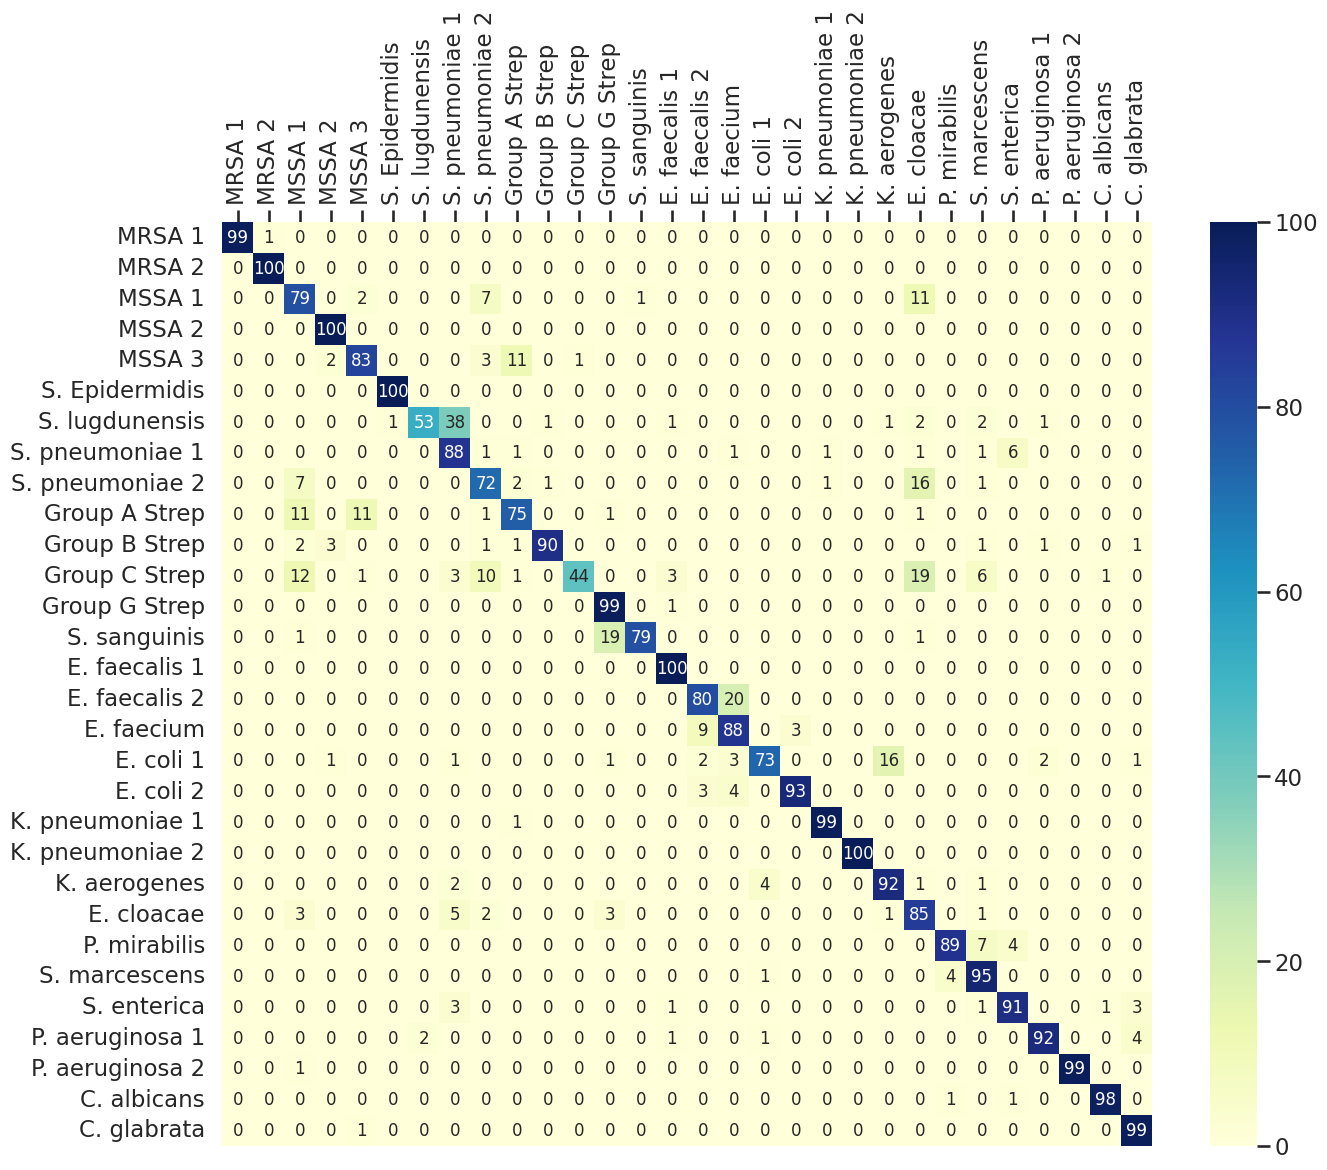

In [ ]:

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

sns.set_context("talk", rc={"font":"Helvetica", "font.size":12})
label = [chem_species[i] for i in order]
#takes a vector of the labels that were previously one-hot encoded
con_mat = confusion_matrix(test_label.argmax(axis=1),
                           prediction.argmax(axis=1))
plt.figure(figsize=(15,12))
con_mat = 100 * con_mat / con_mat.sum(axis=1)[:,np.newaxis]
ax = sns.heatmap(con_mat, annot=True, cmap='YlGnBu', fmt='0.0f',
                 xticklabels=label, yticklabels=label)
ax.xaxis.tick_top()
plt.xticks(rotation=90)
plt.show()